In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import Dense, Activation
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras

In [ ]:
print(os.listdir("/gdrive/My Drive/DerinOgrenmeProje/lung_image_sets"))

['lung_squamous cell carcinoma', 'lung_adenocarcinoma', 'lung_benign tissue']


In [ ]:
DATADIR = "/gdrive/My Drive/DerinOgrenmeProje/lung_image_sets"

CATEGORIES = ['lung_adenocarcinoma', 'lung_squamous cell carcinoma', 'lung_benign tissue']

IMG_SIZE = 100

In [ ]:
all_data =[]

def create_all_data():
    for category in CATEGORIES:
        path=os.path.join(DATADIR, category)
        class_num=CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array=cv2.imread(os.path.join(path,img))
                new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
                all_data.append([new_array,class_num])
            except Exception as e:
                pass
create_all_data()

In [ ]:
print("Toplam Görüntü Sayısı: ", len(all_data))

Toplam Görüntü Sayısı:  15000


In [ ]:
X = []
y = []

for categories, label in all_data:
  X.append(categories)
  y.append(label)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state =42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.10, random_state=42)

In [ ]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

x_val = np.array(x_val)
y_val = np.array(y_val)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(9450, 100, 100, 3)
(4500, 100, 100, 3)
(1050, 100, 100, 3)
(9450,)
(4500,)
(1050,)


In [ ]:
train_yCl = tf.keras.utils.to_categorical(y_train, num_classes=3)
test_yCl = tf.keras.utils.to_categorical(y_test, num_classes=3)
valid_yCl = tf.keras.utils.to_categorical(y_val, num_classes=3)

In [ ]:
model = Sequential()

# Giriş katmanı (Flatten ile görüntüleri vektöre çevirme)
model.add(Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)))


model.add(Dense(256, activation='relu'))
model.add(Dropout(0.15))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(BatchNormalization())

#Output Layer
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
callback_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='model.h5',
        monitor = 'val_accuracy', save_best_only=True, verbose=3
    ),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=3)
]

In [ ]:
history = model.fit(x_train, train_yCl,
                    epochs=50,
                    validation_data=(x_val, valid_yCl),
                    callbacks = callback_list,
                    )

Epoch 1/50
288/296 [============================>.] - ETA: 0s - loss: 0.6563 - accuracy: 0.6596
Epoch 1: val_accuracy improved from -inf to 0.74857, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


296/296 [==============================] - 4s 8ms/step - loss: 0.6537 - accuracy: 0.6612 - val_loss: 0.5284 - val_accuracy: 0.7486
Epoch 2/50
291/296 [============================>.] - ETA: 0s - loss: 0.5198 - accuracy: 0.7271
Epoch 2: val_accuracy improved from 0.74857 to 0.77714, saving model to model.h5
296/296 [==============================] - 2s 7ms/step - loss: 0.5214 - accuracy: 0.7261 - val_loss: 0.4793 - val_accuracy: 0.7771
Epoch 3/50
294/296 [============================>.] - ETA: 0s - loss: 0.4995 - accuracy: 0.7423
Epoch 3: val_accuracy did not improve from 0.77714
296/296 [==============================] - 2s 8ms/step - loss: 0.4995 - accuracy: 0.7423 - val_loss: 0.7182 - val_accuracy: 0.6667
Epoch 4/50
295/296 [============================>.] - ETA: 0s - loss: 0.5147 - accuracy: 0.7421
Epoch 4: val_accuracy did not improve from 0.77714
296/296 [==============================] - 3s 9ms/step - loss: 0.5145 - accuracy: 0.7422 - val_loss: 0.8730 - val_accuracy: 0.6143
Epoch

In [ ]:
res_model = keras.models.load_model('/content/model.h5')

In [ ]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(test_yCl, axis=1)

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average="weighted")
recall = recall_score(y_test_classes, y_pred_classes, average="weighted")
f1_value = f1_score(y_test_classes, y_pred_classes, average="weighted")

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_value)

141/141 [==============================] - 1s 3ms/step
Accuracy: 0.6828888888888889
Precision: 0.6988239633230056
Recall: 0.6828888888888889
F1 Score: 0.6688907936752007


In [ ]:
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 492 1020   12]
 [ 217 1275    0]
 [ 178    0 1306]]


In [ ]:
class_report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.32      0.41      1524
           1       0.56      0.85      0.67      1492
           2       0.99      0.88      0.93      1484

    accuracy                           0.68      4500
   macro avg       0.70      0.69      0.67      4500
weighted avg       0.70      0.68      0.67      4500



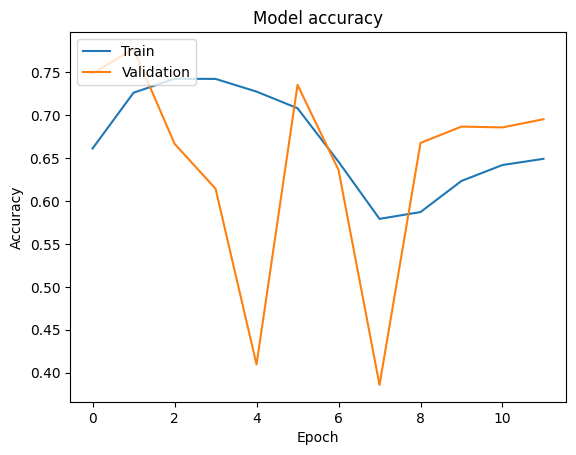

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

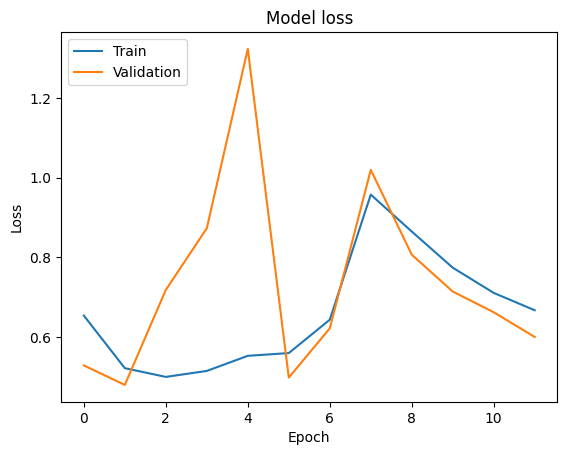

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()